--- Starting Hypothesis Testing and Experiment Evaluation ---
Successfully loaded df_full_ab_test from: C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed\df_full_ab_test_cleaned.csv
Removed 0 rows with NaNs in demographic columns after reload.
df_full_ab_test now has 302289 entries for analysis.
df_full_ab_test info after loading and cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302289 entries, 0 to 302288
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_id              302289 non-null  int64         
 1   visitor_id             302289 non-null  object        
 2   visit_id               302289 non-null  object        
 3   process_step           302289 non-null  object        
 4   date_time              302289 non-null  datetime64[ns]
 5   variation              302289 non-null  object        
 6   clnt_tenure_yr         302289 n

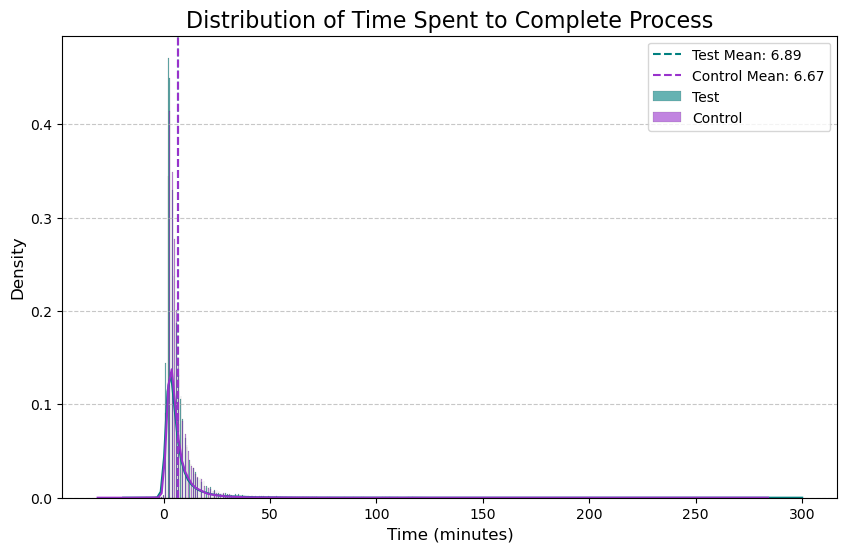


#### Test 3: Error Rate (Proportion Z-test) ####
Test Group: 25785 visits with errors out of 37190 visits. Rate: 0.6933
Control Group: 20178 visits with errors out of 32235 visits. Rate: 0.6260
Z-statistic for Error Rate: 18.7150
P-value for Error Rate: 0.0000
Conclusion: Reject the null hypothesis. The difference in error rates is statistically significant.
Difference in Error Rates (Test - Control): 0.0674
95% Confidence Interval for Difference: (0.0603, 0.0744)
Interpretation: Test group's error rate is significantly HIGHER.

--- Experiment Evaluation and Recommendation ---

**Summary of Hypothesis Test Results:**
Completion Rate: P-value = 0.0000 (Statistically Significant: True)
Average Time Spent: P-value = 0.0193 (Statistically Significant: True)
Error Rate: P-value = 0.0000 (Statistically Significant: True)

**Overall Recommendation:**
The new design (Test group) significantly improves completion rate, but also introduces statistically significant negative impacts on time spen

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For t-test
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep # For proportion tests

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format) # Set float format for cleaner output

print("--- Starting Hypothesis Testing and Experiment Evaluation ---")

# --- Load the Cleaned and Merged DataFrame ---
# Define the path where the processed data is saved
processed_data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed'
input_file_name = 'df_full_ab_test_cleaned.csv'
input_full_path = os.path.join(processed_data_path, input_file_name)

# Load the cleaned and merged DataFrame
try:
    df_full_ab_test = pd.read_csv(input_full_path)
    # Ensure 'date_time' is re-converted to datetime objects after loading from CSV
    df_full_ab_test['date_time'] = pd.to_datetime(df_full_ab_test['date_time'])
    print(f"Successfully loaded df_full_ab_test from: {input_full_path}")

    # Re-apply the specific cleaning for demographic NaNs that was done in the previous notebook
    # This ensures consistency for any demographic-related analyses or statistical tests
    initial_ab_test_rows = len(df_full_ab_test)
    df_full_ab_test.dropna(subset=[
        'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
        'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'
    ], inplace=True)
    print(f"Removed {initial_ab_test_rows - len(df_full_ab_test)} rows with NaNs in demographic columns after reload.")
    print(f"df_full_ab_test now has {len(df_full_ab_test)} entries for analysis.")
    print(f"df_full_ab_test info after loading and cleaning:")
    df_full_ab_test.info()

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure '{input_file_name}' was saved correctly from the previous notebook.")
    exit() # Exit if the file isn't found, as subsequent steps will fail


# --- No need to re-derive KPIs here! They are already in df_full_ab_test ---
# The 'completed_process', 'time_spent_minutes', and 'has_backward_movement' columns
# are now part of df_full_ab_test after being saved and reloaded.
print("\n--- Data Loaded with KPIs Ready for Hypothesis Testing ---")

### --- Hypothesis Testing ---

# Significance level (alpha)
alpha = 0.05
print(f"\nUsing a significance level (alpha) of {alpha}")

#### Test 1: Completion Rate (Proportion Z-test) ####
print("\n#### Test 1: Completion Rate (Proportion Z-test) ####")

# Groups data by unique visits (each person’s session).
#For each visit, it checks:
#   Did they complete the process? (max)
#   Average time spent (mean)
#   Did they go backward (error)? (max)

visit_level_kpis = df_full_ab_test.groupby(['client_id', 'visit_id', 'variation']).agg(
    completed_process=('completed_process', 'max'), # Max will be True if any row in the visit was completed
    time_spent_minutes=('time_spent_minutes', 'mean'), # Take mean, will be NaN for non-completed visits
    has_backward_movement=('has_backward_movement', 'max') # Max will be True if any row in the visit had backward movement
).reset_index()


# Counts of completions and total visits for each group
completions_test = visit_level_kpis[(visit_level_kpis['variation'] == 'Test') & (visit_level_kpis['completed_process'] == True)].shape[0]
attempts_test = visit_level_kpis[visit_level_kpis['variation'] == 'Test'].shape[0]

completions_control = visit_level_kpis[(visit_level_kpis['variation'] == 'Control') & (visit_level_kpis['completed_process'] == True)].shape[0]
attempts_control = visit_level_kpis[visit_level_kpis['variation'] == 'Control'].shape[0]

# Handle division by zero if a group has no attempts (though unlikely in real data)
rate_test = completions_test / attempts_test if attempts_test > 0 else 0
rate_control = completions_control / attempts_control if attempts_control > 0 else 0

print(f"Test Group: {int(completions_test)} completions out of {int(attempts_test)} visits. Rate: {rate_test:.4f}")
print(f"Control Group: {int(completions_control)} completions out of {int(attempts_control)} visits. Rate: {rate_control:.4f}")

# Perform z-test for proportions
count = np.array([completions_test, completions_control])
nobs = np.array([attempts_test, attempts_control])

# Null Hypothesis (H0): There is no difference in completion rates between Test and Control.
# Alternative Hypothesis (H1): There is a difference in completion rates. (Two-sided test)
z_stat_completion, p_value_completion = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-statistic for Completion Rate: {z_stat_completion:.4f}")
print(f"P-value for Completion Rate: {p_value_completion:.4f}")

# Determine significance
if p_value_completion < alpha:
    print(f"Conclusion: Reject the null hypothesis. The difference in completion rates is statistically significant.")
else:
    print(f"Conclusion: Fail to reject the null hypothesis. The difference in completion rates is NOT statistically significant.")

# Calculate Confidence Interval for the difference in proportions
# Note: confint_proportions_2indep returns (lower, upper) for prop1-prop2
diff_prop = rate_test - rate_control

ci_lower_completion, ci_upper_completion = confint_proportions_2indep(
    completions_test, attempts_test,
    completions_control, attempts_control,
    method='wald', alpha=alpha
)
print(f"Difference in Completion Rates (Test - Control): {diff_prop:.4f}")
print(f"{100*(1-alpha):.0f}% Confidence Interval for Difference: ({ci_lower_completion:.4f}, {ci_upper_completion:.4f})")
if ci_lower_completion > 0:
    print("Interpretation: Test group's completion rate is significantly HIGHER.")
elif ci_upper_completion < 0:
    print("Interpretation: Test group's completion rate is significantly LOWER.")
else:
    print("Interpretation: The confidence interval includes zero, suggesting no significant difference or that the effect is too small to reliably detect.")


#### Test 2: Average Time Spent to Complete Process (Independent Samples T-test) ####
print("\n#### Test 2: Average Time Spent (Independent Samples T-test) ####")

# Filter for only completed visits that have a time_spent_minutes value
# 'time_spent_minutes' is already NaN for non-completed visits due to the merge in 02_kpi_calculation_analysis.ipynb
test_durations = visit_level_kpis[(visit_level_kpis['variation'] == 'Test') & (visit_level_kpis['completed_process'] == True)]['time_spent_minutes'].dropna()
control_durations = visit_level_kpis[(visit_level_kpis['variation'] == 'Control') & (visit_level_kpis['completed_process'] == True)]['time_spent_minutes'].dropna()

# Ensure both groups have enough data to perform the test
if len(test_durations) < 2 or len(control_durations) < 2:
    print("Not enough completed visits with valid time spent in one or both groups to perform T-test.")
    p_value_time = np.nan # Set p-value to NaN to indicate test not performed
else:
    print(f"Test Group Avg Duration: {test_durations.mean():.4f} min (N={len(test_durations)})")
    print(f"Control Group Avg Duration: {control_durations.mean():.4f} min (N={len(control_durations)})")
    print(f"Std Dev Test: {test_durations.std():.4f}, Std Dev Control: {control_durations.std():.4f}")

    # Check for equal variances (Levene's test)
    # H0: Variances are equal
    # H1: Variances are not equal
    stat_levene, p_value_levene = stats.levene(test_durations, control_durations)
    print(f"Levene's Test P-value: {p_value_levene:.4f}")

    equal_var = True
    if p_value_levene < alpha:
        print("Levene's Test suggests unequal variances. Performing Welch's T-test (equal_var=False).")
        equal_var = False
    else:
        print("Levene's Test suggests equal variances. Performing Student's T-test (equal_var=True).")
        equal_var = True

    # Perform independent samples t-test
    # Null Hypothesis (H0): There is no difference in average time spent between Test and Control.
    # Alternative Hypothesis (H1): There is a difference in average time spent. (Two-sided test)
    t_stat_time, p_value_time = stats.ttest_ind(test_durations, control_durations, equal_var=equal_var, alternative='two-sided')

    print(f"T-statistic for Average Time Spent: {t_stat_time:.4f}")
    print(f"P-value for Average Time Spent: {p_value_time:.4f}")

    if p_value_time < alpha:
        print(f"Conclusion: Reject the null hypothesis. The difference in average time spent is statistically significant.")
    else:
        print(f"Conclusion: Fail to reject the null hypothesis. The difference in average time spent is NOT statistically significant.")

    # Visualize the distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(test_durations, kde=True, color='teal', label='Test', stat='density', alpha=0.6)
    sns.histplot(control_durations, kde=True, color='darkorchid', label='Control', stat='density', alpha=0.6)
    plt.axvline(test_durations.mean(), color='teal', linestyle='dashed', linewidth=1.5, label=f'Test Mean: {test_durations.mean():.2f}')
    plt.axvline(control_durations.mean(), color='darkorchid', linestyle='dashed', linewidth=1.5, label=f'Control Mean: {control_durations.mean():.2f}')
    plt.title('Distribution of Time Spent to Complete Process', fontsize=16)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


#### Test 3: Error Rate (Proportion Z-test) ####
print("\n#### Test 3: Error Rate (Proportion Z-test) ####")

# Counts of visits with backward movement and total visits for each group
errors_test = visit_level_kpis[(visit_level_kpis['variation'] == 'Test') & (visit_level_kpis['has_backward_movement'] == True)].shape[0]
total_visits_test = visit_level_kpis[visit_level_kpis['variation'] == 'Test'].shape[0]

errors_control = visit_level_kpis[(visit_level_kpis['variation'] == 'Control') & (visit_level_kpis['has_backward_movement'] == True)].shape[0]
total_visits_control = visit_level_kpis[visit_level_kpis['variation'] == 'Control'].shape[0]

# Handle division by zero if a group has no total visits
prop_error_test = errors_test / total_visits_test if total_visits_test > 0 else 0
prop_error_control = errors_control / total_visits_control if total_visits_control > 0 else 0


print(f"Test Group: {int(errors_test)} visits with errors out of {int(total_visits_test)} visits. Rate: {prop_error_test:.4f}")
print(f"Control Group: {int(errors_control)} visits with errors out of {int(total_visits_control)} visits. Rate: {prop_error_control:.4f}")

# Perform z-test for proportions
count_errors = np.array([errors_test, errors_control])
nobs_errors = np.array([total_visits_test, total_visits_control])

# Null Hypothesis (H0): There is no difference in error rates between Test and Control.
# Alternative Hypothesis (H1): There is a difference in error rates. (Two-sided test)
z_stat_error, p_value_error = proportions_ztest(count_errors, nobs_errors, alternative='two-sided')

print(f"Z-statistic for Error Rate: {z_stat_error:.4f}")
print(f"P-value for Error Rate: {p_value_error:.4f}")

# Determine significance
if p_value_error < alpha:
    print(f"Conclusion: Reject the null hypothesis. The difference in error rates is statistically significant.")
else:
    print(f"Conclusion: Fail to reject the null hypothesis. The difference in error rates is NOT statistically significant.")

# Calculate Confidence Interval for the difference in proportions
diff_prop_error = prop_error_test - prop_error_control

ci_lower_error, ci_upper_error = confint_proportions_2indep(
    errors_test, total_visits_test,
    errors_control, total_visits_control,
    method='wald', alpha=alpha
)
print(f"Difference in Error Rates (Test - Control): {diff_prop_error:.4f}")
print(f"{100*(1-alpha):.0f}% Confidence Interval for Difference: ({ci_lower_error:.4f}, {ci_upper_error:.4f})")
if ci_lower_error > 0:
    print("Interpretation: Test group's error rate is significantly HIGHER.")
elif ci_upper_error < 0:
    print("Interpretation: Test group's error rate is significantly LOWER.")
else:
    print("Interpretation: The confidence interval includes zero, suggesting no significant difference or that the effect is too small to reliably detect.")


### --- Experiment Evaluation and Recommendation ---
print("\n--- Experiment Evaluation and Recommendation ---")

print("\n**Summary of Hypothesis Test Results:**")
# Handle potential NaN p-values if a test couldn't be performed (e.g., due to insufficient data after NaN removal)
p_value_completion_display = f"{p_value_completion:.4f}" if not pd.isna(p_value_completion) else "N/A"
# For p_value_time, ensure it's defined before trying to format
p_value_time_display = f"{p_value_time:.4f}" if 'p_value_time' in locals() and not pd.isna(p_value_time) else "N/A (Not enough data)"
p_value_error_display = f"{p_value_error:.4f}" if not pd.isna(p_value_error) else "N/A"

is_significant_completion = p_value_completion < alpha if not pd.isna(p_value_completion) else False
is_significant_time = 'p_value_time' in locals() and p_value_time < alpha if not pd.isna(p_value_time) else False
is_significant_error = p_value_error < alpha if not pd.isna(p_value_error) else False

# Recalculate means for the final summary to ensure they are available even if test not performed
mean_test_duration_summary = test_durations.mean() if 'test_durations' in locals() and not test_durations.empty else np.nan
mean_control_duration_summary = control_durations.mean() if 'control_durations' in locals() and not control_durations.empty else np.nan

print(f"Completion Rate: P-value = {p_value_completion_display} (Statistically Significant: {is_significant_completion})")
print(f"Average Time Spent: P-value = {p_value_time_display} (Statistically Significant: {is_significant_time})")
print(f"Error Rate: P-value = {p_value_error_display} (Statistically Significant: {is_significant_error})")

print("\n**Overall Recommendation:**")

overall_recommendation = ""
recommendation_details = []

# Analyze Completion Rate
if is_significant_completion and diff_prop > 0:
    recommendation_details.append(f"- **Positive:** The Test group has a statistically significant higher completion rate ({rate_test*100:.2f}%) compared to the Control group ({rate_control*100:.2f}%). This indicates better user flow through the process.")
else:
    recommendation_details.append(f"- **Neutral/Negative:** No significant improvement or even a decrease in completion rate for the Test group (Test: {rate_test*100:.2f}%, Control: {rate_control*100:.2f}%).")

# Analyze Average Time Spent
if not is_significant_time:
    recommendation_details.append(f"- **Neutral:** No statistically significant difference in average time spent (Test: {mean_test_duration_summary:.2f} min, Control: {mean_control_duration_summary:.2f} min).")
elif mean_test_duration_summary < mean_control_duration_summary:
    recommendation_details.append(f"- **Positive:** The Test group statistically significantly reduces the average time spent ({mean_test_duration_summary:.2f} min) compared to Control ({mean_control_duration_summary:.2f} min).")
else: # mean_test_duration_summary > mean_control_duration_summary
    recommendation_details.append(f"- **Negative:** The Test group statistically significantly increases the average time spent ({mean_test_duration_summary:.2f} min) compared to Control ({mean_control_duration_summary:.2f} min). This suggests the new process might be slower or more complex.")


# Analyze Error Rate (Backward Movement)
if is_significant_error:
    if diff_prop_error < 0: # Test error rate is lower than Control
        recommendation_details.append(f"- **Positive:** The Test group statistically significantly reduces the error rate ({prop_error_test*100:.2f}%) compared to Control ({prop_error_control*100:.2f}%).")
    else: # Test error rate is higher than Control
        recommendation_details.append(f"- **Negative:** The Test group statistically significantly increases the error rate ({prop_error_test*100:.2f}%) compared to Control ({prop_error_control*100:.2f}%). This indicates more user confusion or navigation issues.")
else:
    recommendation_details.append(f"- **Neutral:** No statistically significant difference in error rate (Test: {prop_error_test*100:.2f}%, Control: {prop_error_control*100:.2f}%).")


# Formulate the overall recommendation based on corrected logic for NaNs
# Check if tests actually yielded significant results and in the desired direction
sig_comp_pos = is_significant_completion and diff_prop > 0
sig_time_pos = is_significant_time and mean_test_duration_summary < mean_control_duration_summary if not pd.isna(mean_test_duration_summary) and not pd.isna(mean_control_duration_summary) else False
sig_error_pos = is_significant_error and diff_prop_error < 0 # lower error rate is positive

sig_time_neg = is_significant_time and mean_test_duration_summary > mean_control_duration_summary if not pd.isna(mean_test_duration_summary) and not pd.isna(mean_control_duration_summary) else False
sig_error_neg = is_significant_error and diff_prop_error > 0 # higher error rate is negative


if sig_comp_pos and not sig_time_neg and not sig_error_neg:
    overall_recommendation = "Based on the analysis, the new design (Test group) shows a statistically significant improvement in completion rate, and either no significant negative impact or even positive impacts on time spent and error rate. Therefore, it is **recommended to launch the new design**."
elif sig_comp_pos and (sig_time_neg or sig_error_neg):
    overall_recommendation = "The new design (Test group) significantly improves completion rate, but also introduces statistically significant negative impacts on time spent or error rate. This presents a trade-off. **Further investigation is needed** to understand the root causes of increased time and errors, or to find a way to mitigate these negative impacts while retaining the higher completion rate. A partial rollout or A/B testing of specific components might be considered."
else:
    overall_recommendation = "The new design (Test group) does not consistently show a clear, overall positive impact across all key metrics, or it introduces significant negative trade-offs. It is **recommended NOT to launch the new design as is**. Further iteration on the design is required to address the identified issues and re-test."


print(overall_recommendation)
print("\nRecommendation Details:")
for detail in recommendation_details:
    print(detail)


print("\n--- Hypothesis Testing and Evaluation Complete ---")